In [1]:
from scipy import special as sp
import numpy as np

from matplotlib import pyplot as plt

# Introduction

The purpose of this code is to prototype the Newton-Raphson method for intercept aproximation, before implimenting it in JULES. Since I can't use external libraries in JULES, the same limitation applies here (excluding plotting and general assesment).

Within JULES we need to calcualte the leaf water potential, $\psi_l$, given the rtanspiration rate, $E$, the rootzone water potential, $\psi_r$, and the xylem conductance as a function of water potential, $k(\psi)$. These are related by the following integral;

$$ E(\psi_{l}, \psi{r}) = \int_{\psi_r}^{\psi_l} k(\psi) d\psi$$

There are two models for conductance, the cumulative Weibul distribution;

$$ k(\psi) = e^{-(\frac{\psi}{b})^c} $$

and the SOX conductance model;

$$ k(\psi) = \frac{1}{1 + (\frac{\psi}{b})^c} $$

Writing this in the appropriate form for the Newton-Raphson method we want to find the value of $\psi_l$ that satisfies;

$$ f(\psi_l) = \int_{\psi_r}^{\psi_l} k(\psi) d\psi - E_{obs} = 0 $$

Where $E_{obs}$ is the observed transpiration rate.

## Conductance equations

The code below impliments the cumulative Weibul and SOX xylem conductance models.

In [2]:
def k_CW(psi, k_max, b, c):
    return k_max * np.exp(-(psi/b)**c)

def k_SOX(psi, k_max, b, c):
    return k_max / (1 + (psi/b)**c)

# The incompleat gamma function

The integral of the Cumulative Weibull hydraulic conductance models requiers the calculation of an incomplete gamma function. The incompleat gamma function is defined as the integral;

$$ \gamma(a,x) = \int_{0}^{x} t^{a-1} e^{-t} dt $$

## The gamma function

Before calculating the incompleat gamma function we need to calculate the compleate gamma function defined as;

$$ \Gamma(a) = \int_{0}^{\infty} t^{a-1} e^{-t} dt $$

The code bellow is a reimplimentation of the gammaln subroutine on page 1085 of Numerical Methods in FORTRAN 90. The funcion has been converted to output $\Gamma(a)$ instead of $ln(\Gamma(a))$.

In [3]:
def gamma(a):
    """
    Estimates the normalised gamma function evaluated at a.
    """

    # Coeficients taken from Numerical recipies for Fortran 90 volume 1 page 207
    coefficients = [ 76.18009172947146,
                    -86.50532032941677,
                     24.01409824083091,
                    - 1.231739572450155,
                      0.1208650973866179e-2,
                    - 0.5395239384953e-5]
    coefficients = np.asarray(coefficients)
    n_array = [float(i) for i in range(0,6)]
    n_array = np.asarray(n_array)

    gamma = np.power(a + 5.5, a + 0.5)
    gamma *= np.exp(-a-5.5) 
    gamma *= (2.5066282746310005/a)
    gamma *= (1.000000000190015 + np.sum(coefficients / (a + 1. + n_array)))

    return gamma

a = 0.296

print("-- gamma aproximation -- ")
print("gamma code = ", gamma(a))
print("gamma expected = ", sp.gamma(a))
print("difference = ", gamma(a) - sp.gamma(a))

-- gamma aproximation -- 
gamma code =  3.0340758042723905
gamma expected =  3.0340758042721934
difference =  1.971756091734278e-13


The code bellow plots the gamma function calculated using the code above, comparing it to that given by the gamma function implimented in scipy.special (imported as sp)

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/3555991977.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  gamma *= (2.5066282746310005/a)


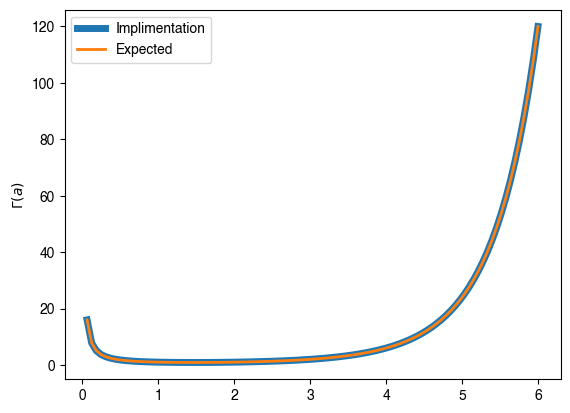

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/3580742751.py:15: RuntimeWarning: invalid value encountered in subtract
  plt.plot(a, gamma_implementation - gamma_expected)


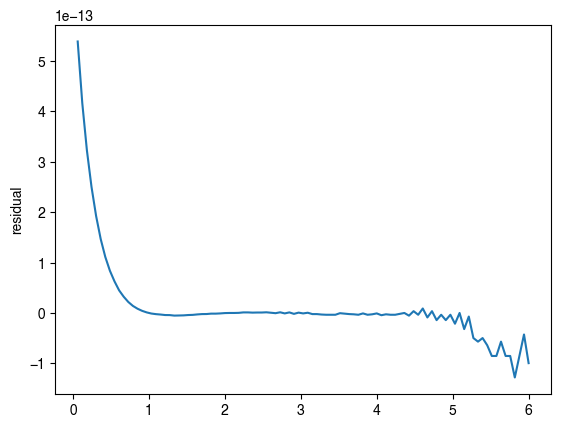

In [4]:
a = np.linspace(0,6,100)

gamma_implementation = np.zeros(len(a))
for i in range(len(a)):
    gamma_implementation[i] = gamma(a[i])

gamma_expected = sp.gamma(a)

plt.plot(a, gamma_implementation, label = "Implimentation", linewidth = 5)
plt.plot(a, gamma_expected, label = "Expected", linewidth = 2)
plt.ylabel("$\Gamma(a)$")
plt.legend()
plt.show()

plt.plot(a, gamma_implementation - gamma_expected)
plt.ylabel("residual")
plt.show()

## Aproximating the incompleat gamma function

The code below implements the aproximation of an incompeat gamma funcion described in [Numerical Recipes in Fortran 90](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=http://www.elch.chem.msu.ru/tch/group/FortranBooks/NumericalRecipesinF90.pdf&ved=2ahUKEwi205GP54yGAxXNVUEAHXcTCC0QFnoECBYQAQ&usg=AOvVaw3qMx5yX0EoYPvCmOY3pJJC). Specificaly it is a reimplimentation of the gser subroutine on page 1090.

In [5]:
def incompleat_gamma_series(a,x, N = 100, precision = 0.00001, verbose = False):
    """
    Estimates the incompleat normalised gamma function using a series expansion.
    """

    denominator = a
    summ = 1./a
    step = summ

    if(verbose):
        print("denominator: ", denominator)
        print("step: ", step)
        print("sum: ", summ)

    for i in range(0,N):
        denominator += 1.
        step *= x/denominator
        summ += step

        if(verbose):
            print("\nitter: ", i)
            print("denominator: ", denominator)
            print("step: ", step)
            print("sum: ", summ)

        if(abs(step) < abs(summ) * precision):
            if(verbose):
                print("itterations = ", i)
            break
    if(verbose):
        print("\nScale: ", np.exp(-x) * np.power(x,a))
    
    return summ  * np.exp(-x) * np.power(x,a)

def norm_incompleat_gamma_series(a, x,  N = 100, precision = 0.00001, verbose = False):
    """
    Estimates the incompleat gamma function using a series expansion.
    """
    return incompleat_gamma_series(a, x, N, precision, verbose) / gamma(a)

a = 0.368
x = 3.32e-6



result = norm_incompleat_gamma_series(a,x, N = 100, precision=-1, verbose = True)

print("-- incompleat gamma implimentation --")
print("\nincompleat gamma code = ", result)
print("incompleat gamma expected = ", sp.gammainc(a,x))
print("difference = ", result - sp.gammainc(a,x))

denominator:  0.368
step:  2.717391304347826
sum:  2.717391304347826

itter:  0
denominator:  1.3679999999999999
step:  6.594838545639462e-06
sum:  2.7173978991863716

itter:  1
denominator:  2.368
step:  9.246141879866137e-12
sum:  2.7173978991956176

itter:  2
denominator:  3.368
step:  9.114367886328852e-18
sum:  2.7173978991956176

itter:  3
denominator:  4.368
step:  6.927587312869e-24
sum:  2.7173978991956176

itter:  4
denominator:  5.368
step:  4.284573375321363e-30
sum:  2.7173978991956176

itter:  5
denominator:  6.368
step:  2.2337913954250825e-36
sum:  2.7173978991956176

itter:  6
denominator:  7.368
step:  1.006540096744201e-42
sum:  2.7173978991956176

itter:  7
denominator:  8.368
step:  3.9934430224554816e-49
sum:  2.7173978991956176

itter:  8
denominator:  9.368
step:  1.415268022475683e-55
sum:  2.7173978991956176

itter:  9
denominator:  10.368
step:  4.531915349748522e-62
sum:  2.7173978991956176

itter:  10
denominator:  11.368
step:  1.3235361507006592e-68
sum: 

The code bellow plots the incompleat gamma series values as a function of x, comparing the results to the expected value from scipy.

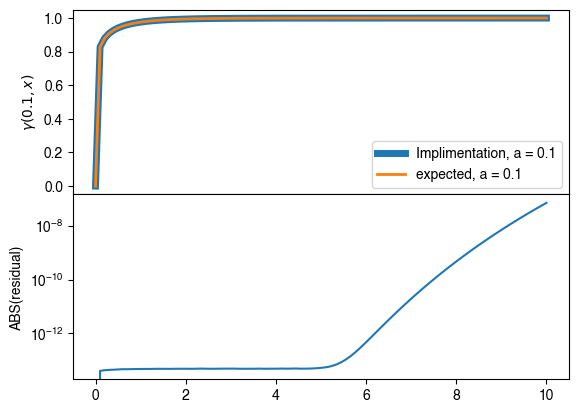

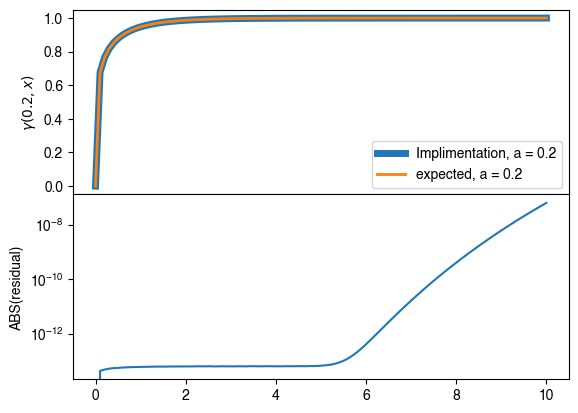

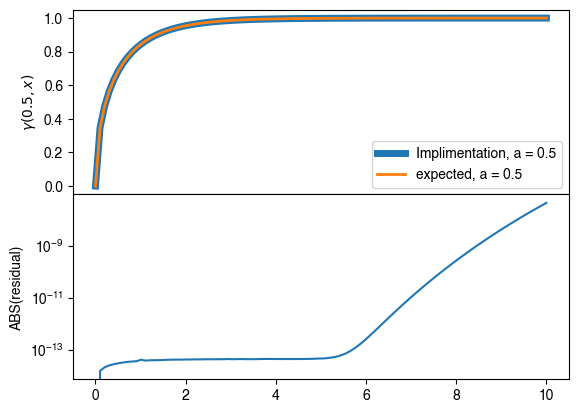

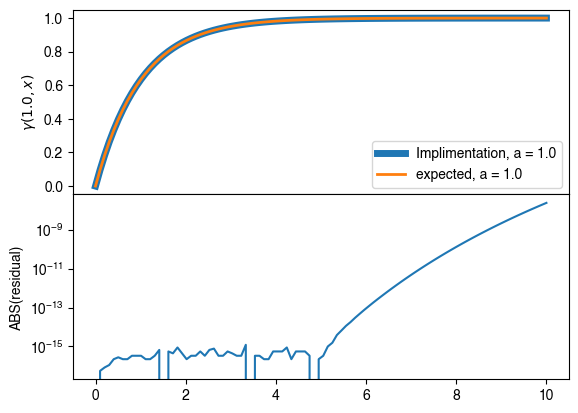

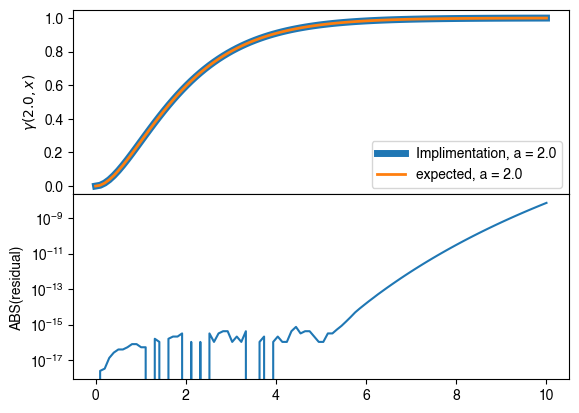

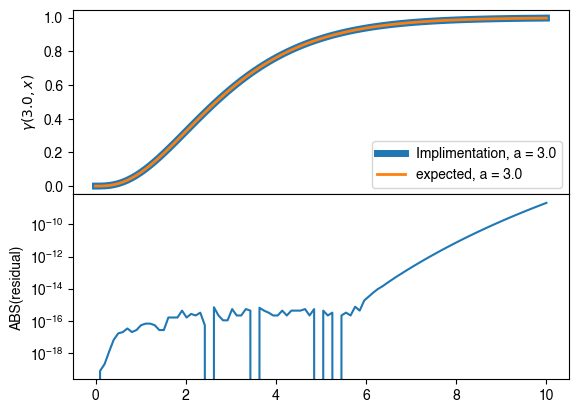

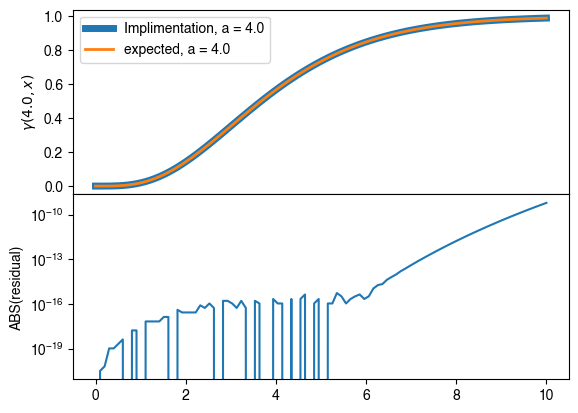

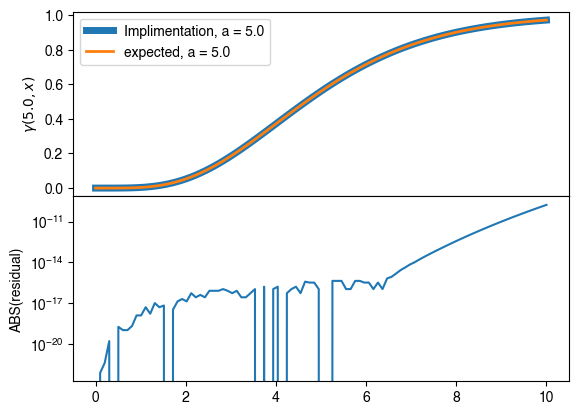

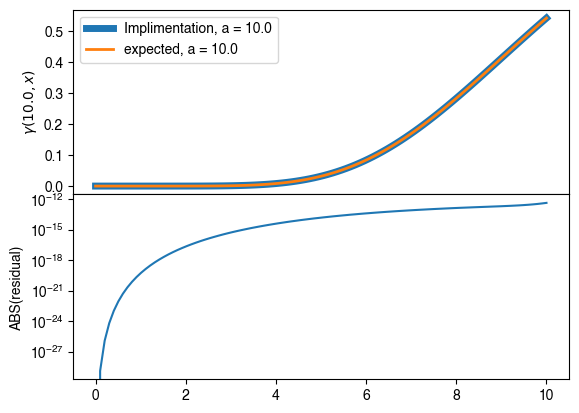

In [6]:
x = np.linspace(0,10,100)
a = [0.1, 0.2, 0.5, 1., 2., 3., 4., 5., 10.]

y_implimentation = np.zeros((len(a),len(x)))
y_expected = np.zeros((len(a),len(x)))

for i in range(len(a)):
    for j in range(len(x)):
        y_implimentation[i,j] = norm_incompleat_gamma_series(a[i],x[j], N = 30, precision = -0.0001)
    
    y_expected[i,:] = sp.gammainc(a[i],x)

for i in range(len(a)):
    fig, axs = plt.subplots(2,1, sharex = True)
    axs[0].plot(x,y_implimentation[i], label = "Implimentation, a = " + str(a[i]), linewidth = 5)
    axs[0].plot(x,y_expected[i], label = "expected, a = " + str(a[i]), linewidth = 2)

    axs[1].plot(x, np.abs(y_implimentation[i] - y_expected[i]))

    # Formating
    axs[0].set_ylabel("$\gamma(" + str(a[i]) + ",x)$")
    axs[1].set_ylabel("ABS(residual)")
    axs[1].set_yscale("log")
    axs[0].legend()
    fig.subplots_adjust(hspace=0)
    plt.show()

# The Gaussian hypergeometric series

The integral of the SOX conductance requiers the use of the Gaussian Hypergeometric series ($_2F_1(a_f, b_f; c_f; x)$). 

## $|x| < 1$

When $|x| < 1$ the hypergeometric series is defined as:

$$ _2F_1(a_f,b_f;c_f;x) = \sum_{n=0}^{\infty} \frac{(a_f)_n(b_f)_n}{(c_f)_n} \frac{x^n}{n!} $$

Where $(q)_n$ denotes the rising factorial, defined as;

$$ (q)_n = \prod_{i=0}^n q+n $$

Note that $(q)_0 = 1$ for all $q$.

Let $S_n$ be the $n^{th}$ component of the sum;

$$ s_n = \frac{(a_f)_n(b_f)_n}{(c_f)_n} \frac{x^n}{n!} $$

Where $s_0 = 1$. We can rewrite the above equation to define $s_{n+1}$ relative to $s_n$;

$$ s_{n+1} = \frac{(a_f+n)(b_f+n)}{(c_f+n)} \frac{x}{n+1} s_n $$

This means that we can simplify the calculation of the $(n+1)^{th}$ component of the sumation by using the $n^{th}$ component.

This still leaves issues when $|x| > 1$, with the sum above not converging. Note there is no solution when $|x| = 1$ for real $x$.

A truncated version of this sum is defined bellow;

In [7]:
def HGS_2F1_mod_of_x_lessthan_1(a_f, b_f, c_f, x, itters = 100, precision = 0.01, verbose = False):

    """
    Calculate the hypergeometric series upto n = itters or the step change is less than prescision.
    """
    
    if(np.abs(x) >= 1.):
        print("error: |" + str(x) + "| >= 1")
        return 0
    
    F_out = 1
    step = F_out

    for i in range(itters):

        if(verbose):
            print("\nIter = ", i)
            print("step = ", step)
            print("F_out = ", F_out)
        
        step *= ((a_f+i)*(b_f+i)/(c_f+i)) * (x/(i+1))
        F_out += step

        if(np.abs(step) < precision):
            break

    return F_out

a_f = 1
b_f = 1/(2.87) # 1/c
c_f = 1 + 1/(2.87) # 1 + 1/C
x = -(1/2.)**(2.87) # -(psi/b)^c

print("a_f = ", a_f)
print("b_f = ", b_f)
print("c_f = ", c_f)
print("x = ", x)

HGS_2F1_predicted = HGS_2F1_mod_of_x_lessthan_1(a_f, b_f, c_f, x, itters = 100, precision = 0.00001, verbose = True)
HGS_2F1_true      = sp.hyp2f1(a_f, b_f, c_f, x)

print("-- HGS --")
print("HGS predicted = ", HGS_2F1_predicted)
print("HGS expected  = ", HGS_2F1_true)
print("difference    = ", HGS_2F1_predicted - HGS_2F1_true)

a_f =  1
b_f =  0.3484320557491289
c_f =  1.348432055749129
x =  -0.13678671265759243

Iter =  0
step =  1
F_out =  1

Iter =  1
step =  -0.03534540378749158
F_out =  0.9646545962125084

Iter =  2
step =  0.002776054118645513
F_out =  0.9674306503311539

Iter =  3
step =  -0.00026632280092724926
F_out =  0.9671643275302267

Iter =  4
step =  2.805182135197228e-05
F_out =  0.9671923793515788
-- HGS --
HGS predicted =  0.967189259663435
HGS expected  =  0.9671895812513519
difference    =  -3.215879168516622e-07


Now we can plot this as a function of x and compare it to the result from scipy.

error: |-1.5| >= 1
error: |-1.4737373737373738| >= 1
error: |-1.4474747474747476| >= 1
error: |-1.4212121212121211| >= 1
error: |-1.394949494949495| >= 1
error: |-1.3686868686868687| >= 1
error: |-1.3424242424242423| >= 1
error: |-1.316161616161616| >= 1
error: |-1.2898989898989899| >= 1
error: |-1.2636363636363637| >= 1
error: |-1.2373737373737375| >= 1
error: |-1.211111111111111| >= 1
error: |-1.1848484848484848| >= 1
error: |-1.1585858585858586| >= 1
error: |-1.1323232323232322| >= 1
error: |-1.106060606060606| >= 1
error: |-1.0797979797979798| >= 1
error: |-1.0535353535353535| >= 1
error: |-1.0272727272727273| >= 1
error: |-1.001010101010101| >= 1
error: |1.0212121212121215| >= 1
error: |1.0474747474747477| >= 1
error: |1.0737373737373739| >= 1
error: |1.1| >= 1


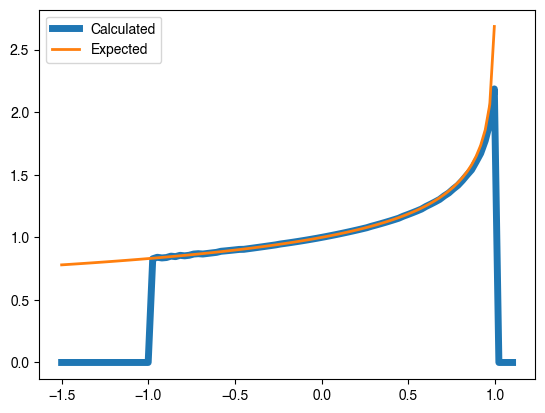

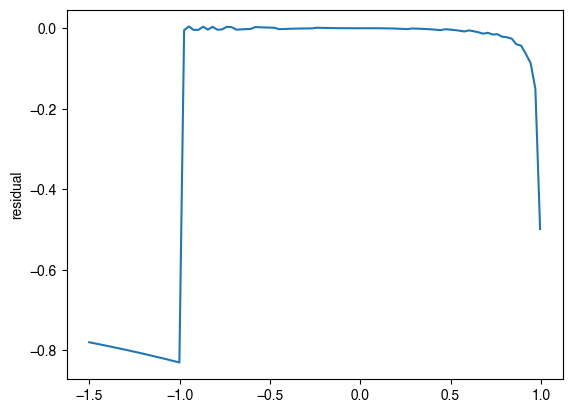

In [8]:
x = np.linspace(-1.5,1.1,100)

a_f = 1
b_f = 1/(2.87)
c_f = 1 + 1/(2.87)

y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = HGS_2F1_mod_of_x_lessthan_1(a_f, b_f, c_f, x[i])

y_expected = sp.hyp2f1(a_f, b_f, c_f, x)

plt.plot(x, y, label = "Calculated", linewidth = 5)
plt.plot(x, y_expected, label = "Expected", linewidth = 2)
plt.legend()
plt.show()

plt.plot(x, y - y_expected)
plt.ylabel("residual")
plt.show()

The code bellow repeats the analysis above but does so over a range of water potentials. Note that $x = -(\psi/b)^c$.

-- conductance model constants --
b_con =  -2
c_con =  2.8744691179161412
error: |-1.0293107258612992| >= 1
error: |-1.1521480950905314| >= 1
error: |-1.2841686141326103| >= 1
error: |-1.4256804180691538| >= 1
error: |-1.5769902119826391| >= 1
error: |-1.7384033283613995| >= 1
error: |-1.9102237803010211| >= 1
error: |-2.092754310939877| >= 1
error: |-2.2862964395082614| >= 1
error: |-2.491150504321686| >= 1
error: |-2.7076157030075927| >= 1
error: |-2.935990130219644| >= 1
error: |-3.176570813063808| >= 1
error: |-3.4296537444347557| >= 1
error: |-3.6955339144389945| >= 1
error: |-3.9745053400619788| >= 1
error: |-4.266861093219846| >= 1
error: |-4.572893327321891| >= 1
error: |-4.892893302457265| >= 1
error: |-5.227151409308152| >= 1
error: |-5.575957191881987| >= 1
error: |-5.939599369146504| >= 1
error: |-6.318365855643774| >= 1
error: |-6.712543781152567| >= 1
error: |-7.122419509462277| >= 1
error: |-7.548278656316196| >= 1
error: |-7.990406106577135| >= 1
error: |-8.449086030663

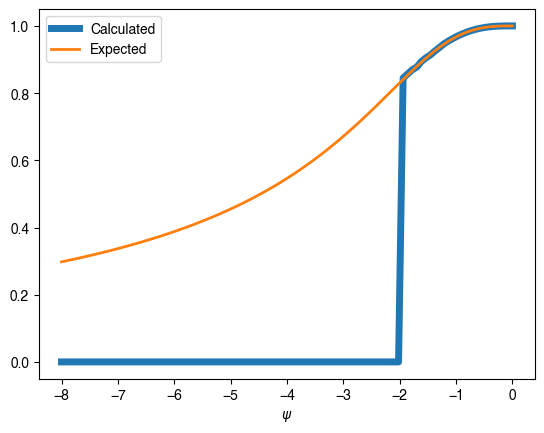

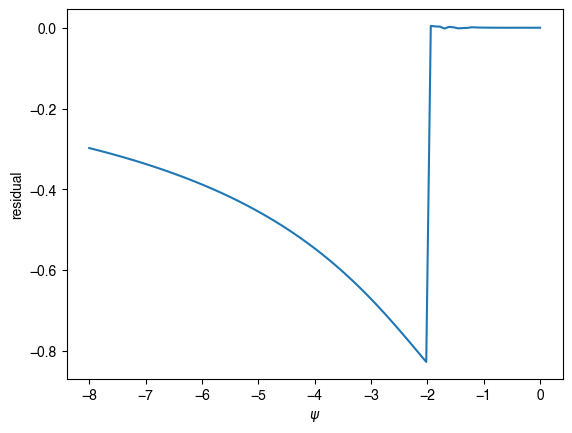

In [9]:
p50 = -2 # MPa
p88 = -4 # MPa

psi = -np.linspace(0,8,100) #MPa
b_con = p50 #MPa
c_con = np.log(1/0.12-1) / np.log(p88/p50)

print("-- conductance model constants --")
print("b_con = ", b_con)
print("c_con = ", c_con)

a_f = 1
b_f = 1/(c_con)
c_f = 1 + 1/(c_con)
x = -(psi/b_con)**c_con

y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = HGS_2F1_mod_of_x_lessthan_1(a_f, b_f, c_f, x[i])
y_expected = sp.hyp2f1(a_f, b_f, c_f, x)

plt.plot(psi, y, label = "Calculated", linewidth = 5)
plt.plot(psi, y_expected, label = "Expected", linewidth = 2)
plt.xlabel("$\psi$")
plt.legend()
plt.show()

plt.plot(psi, y - y_expected)
plt.xlabel("$\psi$")
plt.ylabel("residual")
plt.show()

## $x < 0$

As we can see this doesn't work when $-(\psi/b)^c \leq -1$. The Gaussian hyper geometric function does exist in this reagion, to find it we need to make use of analytic continuation. [W.Becken 1997](https://www.sciencedirect.com/science/article/pii/S0377042700002673/) gives a range of solutions for the analytic continuation of the Gaussian hyper geometric function, we use equation B.5.

$$ H(a_f, b_f; c_f; x) = (1-x)^{-a_f}H(a_f, c_f-b_f; c_f; \frac{x}{x-1}) $$

Where;

$$ H(a_f, b_f; c_f; x) = \frac{_2F_1(a_f, b_f; c_f; x)}{\Gamma(c_f)} $$

Given this the equation simplifies to;

$$ _2F_1(a_f, b_f; c_f; x) = (1-x)^{-a_f} {_2F_1}(a_f, c_f-b_f; c_f; \frac{x}{x-1}) $$

This method aplies when $x \leq 0$ and $c_f - a_f - b_f = 0$. For the SOX conductance model we know that $x = -(\psi/b)^c \leq 0$ and $c_f - a_f - b_f = (1 + 1/c) - 1 - 1/c = 0$, hence this solution works for all $\psi_l < 0$.

The code below impliments this function.

In [10]:
def HGS_2F1_x_lessthan_or_equal_0(a_f, b_f, c_f, x, itters = 100, precision = 0.01, verbose = False):

    """
    Calculate the hypergeometric series when x is less than 0.
    """
    
    if(x > 0.):
        print("error: " + str(x) + " > 0")
        return 0
    
    return np.power(1-x, -a_f) * HGS_2F1_mod_of_x_lessthan_1(a_f, c_f - b_f, c_f, x / (x - 1), itters, precision, verbose) 

a_f = 1
b_f = 1/(-0.44) # 1/c
c_f = 1 + 1/(-0.44) # 1 + 1/C
x = -(1/2.)**(-0.44) # -(psi/b)^c

print("a_f = ", a_f)
print("b_f = ", b_f)
print("c_f = ", c_f)
print("x = ", x)

HGS_2F1_predicted = HGS_2F1_x_lessthan_or_equal_0(a_f, b_f, c_f, x, itters = 100, precision = 0.01, verbose = True)
HGS_2F1_true      = sp.hyp2f1(a_f, b_f, c_f, x)

print("-- HGS --")
print("HGS predicted = ", HGS_2F1_predicted)
print("HGS expected  = ", HGS_2F1_true)
print("difference    = ", HGS_2F1_predicted - HGS_2F1_true)

a_f =  1
b_f =  -2.272727272727273
c_f =  -1.272727272727273
x =  -1.3566043274476718

Iter =  0
step =  1
F_out =  1

Iter =  1
step =  -0.4523047792634271
F_out =  0.5476952207365728

Iter =  2
step =  1.9094097245490154
F_out =  2.457104945285588

Iter =  3
step =  4.534084505924316
F_out =  6.9911894512099035

Iter =  4
step =  6.044428059493373
F_out =  13.035617510703275

Iter =  5
step =  6.3791552981865705
F_out =  19.414772808889847

Iter =  6
step =  5.911392293629402
F_out =  25.326165102519248

Iter =  7
step =  5.0389922438065
F_out =  30.36515734632575

Iter =  8
step =  4.051840488080037
F_out =  34.416997834405784

Iter =  9
step =  3.120486743432824
F_out =  37.537484577838605

Iter =  10
step =  2.3246770526540796
F_out =  39.862161630492686

Iter =  11
step =  1.6867211597766305
F_out =  41.54888279026932

Iter =  12
step =  1.197843205898029
F_out =  42.74672599616735

Iter =  13
step =  0.8356425224079196
F_out =  43.582368518575265

Iter =  14
step =  0.5742725651

Now we can plot this as a function of x and compare it to the result from scipy.

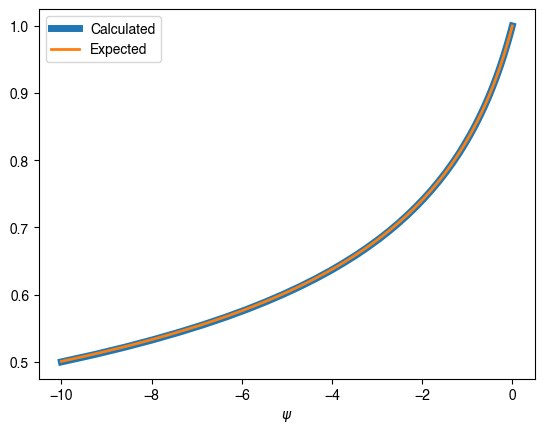

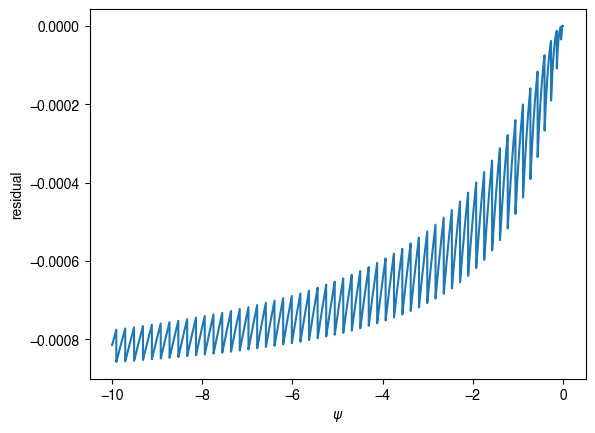

In [11]:
x = np.linspace(-10,0,10000)

a_f = 1
b_f = 1/(2.87)
c_f = 1 + 1/(2.87)

y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = HGS_2F1_x_lessthan_or_equal_0(a_f, b_f, c_f, x[i], precision = 0.001)

y_expected = sp.hyp2f1(a_f, b_f, c_f, x)

plt.plot(x, y, label = "Calculated", linewidth = 5)
plt.plot(x, y_expected, label = "Expected", linewidth = 2)
plt.xlabel("$\psi$")
plt.legend()
plt.show()

plt.plot(x, y - y_expected)
plt.xlabel("$\psi$")
plt.ylabel("residual")
plt.show()

The code bellow repeats the analysis above but does so over a range of water potentials. Note that $x = -(\psi/b)^c$.

-- conductance model constants --
b_con =  -2
c_con =  2.8744691179161412


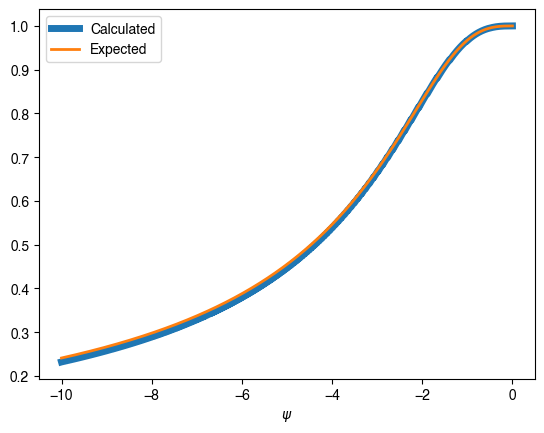

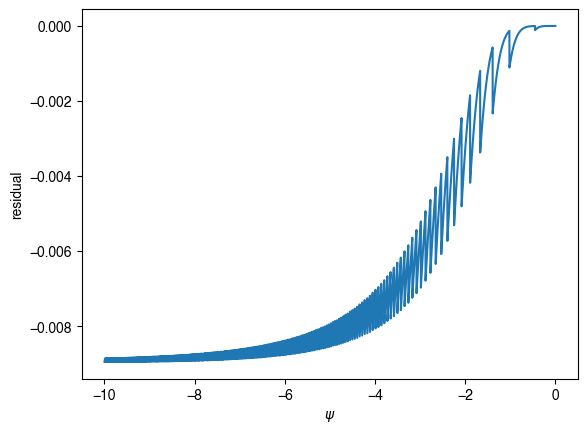

In [12]:
p50 = -2 # MPa
p88 = -4 # MPa

psi = -np.linspace(0,10,10000) #MPa
b_con = p50 #MPa
c_con = np.log(1/0.12-1) / np.log(p88/p50)

print("-- conductance model constants --")
print("b_con = ", b_con)
print("c_con = ", c_con)

a_f = 1
b_f = 1/(c_con)
c_f = 1 + 1/(c_con)
x = -(psi/b_con)**c_con

y = np.zeros(len(x))
for i in range(len(x)):
    y[i] = HGS_2F1_x_lessthan_or_equal_0(a_f, b_f, c_f, x[i], itters = 1000, precision = 0.01)
y_expected = sp.hyp2f1(a_f, b_f, c_f, x)

plt.plot(psi, y, label = "Calculated", linewidth = 5)
plt.plot(psi, y_expected, label = "Expected", linewidth = 2)
plt.xlabel("$\psi$")
plt.legend()
plt.show()

plt.plot(psi, y - y_expected)
plt.xlabel("$\psi$")
plt.ylabel("residual")
plt.show()

# The conductance integral

Now that we have a set of functions for calculating the incompleat gamma function we can calculate the integral of the xylem conductance as outlined in the introduction

## Cumulative Weibull distribution

As described in the introduction the cumulative Weibull distribution has the form;

$$ k(\psi) = e^{-(\frac{\psi}{b})^c} $$

To find the leaf water potential using the Newton-Raphson method we need a method for solving the transpiration;

$$E(\psi_l, \psi_r) = \int_{\psi_r}^{psi_l} k_{max} e^{-(\frac{\psi}{b})^c} d\psi$$

By substituting in $x = (\psi/b)^c$ the integral can be rewriten in the form;

$$E(\psi_l, \psi_r) = k_{max} \frac{b}{c} \int_{x_r}^{x_l} e^{-x} x^{\frac{1}{c}-1} dx$$

Hence we can write;

$$E(\psi_l, \psi_r) = k_{max} \frac{b}{c} [\gamma(1/c,x)]_{x_r}^{x_l} $$

The code below implients this equation.

In [13]:
def transpiration_CW(psi_r, psi_l, k_max, b, c, N = 100, precision = 0.001):
    """
    Calcualtes the transpiration rate between two water potentials when the xylem conductance
    is modeld as a cuulative Weibull distribution.
    """

    # Convert the limits into the appropriate form
    x_l = np.power(psi_l/b,c)
    x_r = np.power(psi_r/b,c)


    # calculate the multiplyer infront of the integral
    multiplyer = k_max * b/c
    
    return multiplyer * (incompleat_gamma_series(1/c,x_r, N, precision) - incompleat_gamma_series(1/c,x_l, N, precision))

psi_r = -0.5 # MPa
psi_l = -1.0 # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

print("Transpiration gamma aproximation: ", transpiration_CW(psi_r, psi_l, k_max, b, c))

psi = np.linspace(psi_r,psi_l, 10000)
k = k_CW(psi, k_max, b, c)
E = -np.cumsum(k)[-1] * (psi[1]-psi[0]) 

print("Transpiration numerical aproximation: ", E)
print("Difference: ", transpiration_CW(psi_r, psi_l, k_max, b, c) - E)

Transpiration gamma aproximation:  0.4981051387753405
Transpiration numerical aproximation:  0.4981549096960598
Difference:  -4.977092071928313e-05


Lets plot this as a function of leaf water potential and compare it to a numerical solution of the integral.

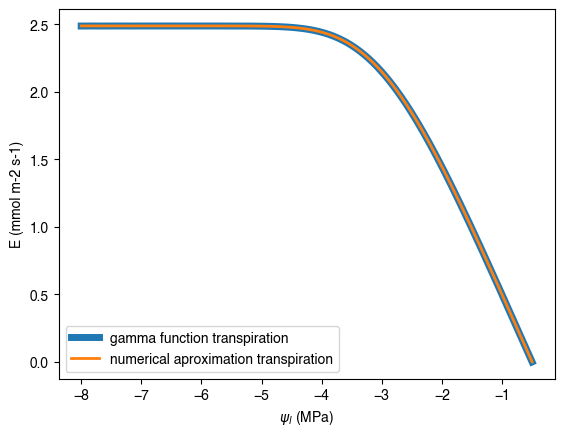

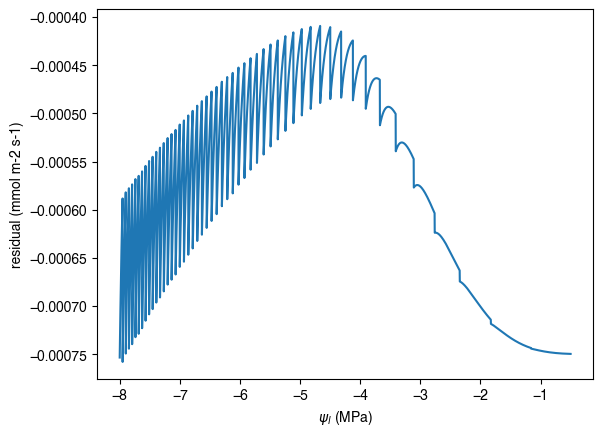

In [14]:
# -- Setup parameters --
psi_r = -0.5 # MPa
psi_l = np.linspace(psi_r, -8, 10000) # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

# -- calculate the transpiration rate using the gamma aproximation code --
transpiration_gamma_aproximation = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    transpiration_gamma_aproximation[i] = transpiration_CW(psi_r, psi_l[i], k_max, b, c, N = 100, precision=0.0001)

# -- calculate the transpiration using a numerical approach --
k_psi = k_CW(psi_l, k_max, b, c)

transpiratio_numerical_aproximation = -np.cumsum(k_psi) * (psi_l[1]-psi_l[0])

plt.plot(psi_l, transpiration_gamma_aproximation, label = "gamma function transpiration", linewidth = 5)
plt.plot(psi_l, transpiratio_numerical_aproximation, label = "numerical aproximation transpiration", linewidth = 2)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("E (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.plot(psi_l, transpiration_gamma_aproximation - transpiratio_numerical_aproximation)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("residual (mmol m-2 s-1)")
plt.show()

## SOX conductance model

As described in the introduction the SOX conductance model takes the form;

$$ k(\psi) = \frac{1}{1 + (\frac{\psi}{b})^c} $$

To find the leaf water potential using the Newton-Raphson method we need a mehtod for solving the transpiration integral;

$$ E(\psi_l, \psi_r) = \int_{\psi_r}^{\psi_l} \frac{1}{1 + (\frac{\psi}{b})^c} d\psi $$

Using [WolframAlpah](https://www.wolframalpha.com/input?i=integral&assumption=%7B%22C%22%2C+%22integral%22%7D+-%3E+%7B%22Calculator%22%2C+%22dflt%22%7D&assumption=%7B%22F%22%2C+%22Integral%22%2C+%22integrand%22%7D+-%3E%22k%2F%281-%28x%2Fb%29%5Ec%29%22) to calculate the integral givs;

$$ E(\psi_l, \psi_r) = k_{max} [\psi \;\; _2F_1(1,\frac{1}{c};1+\frac{1}{c};-(\frac{\psi}{b})^c)]_{\psi_r}^{\psi_l} $$

Where $_2F_1()$ is the hypergeometric seris described previously.

The code bellow impliments the transpiration equation.

In [15]:
def transpiration_SOX(psi_r, psi_l, k_max, b, c, N = 100, precision = 0.001, verbose = False):
    """
    Calcualtes the transpiration rate between two water potentials when the xylem conductance
    is modeld as in SOX 2018.
    """

    a_2f1 = 1.
    b_2f1 = 1/c
    c_2f1 = 1 + 1/c
    x_l = -(psi_l/b)**c
    x_r = -(psi_r/b)**c

    if(verbose):
        print("\n-- transpiration SOX --")
        print("a_2f1 = ", a_2f1)
        print("b_2f1 = ", b_2f1)
        print("c_2f1 = ", c_2f1)
        print("x_2f1_l = ", x_l)
        print("x_2f1_r = ", x_r)
        print("HGS_2F1(x_l) = ", HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_l, N, precision))
        print("HGS_2F1(x_r) = ", HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_r, N, precision))
    
    return k_max * (psi_r * HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_r, N, precision) - psi_l * HGS_2F1_x_lessthan_or_equal_0(a_2f1, b_2f1, c_2f1, x_l, N, precision))

psi_r = -0.2 # MPa
psi_l = -4.0 # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
p50 = -2 # MPa
p88 = -4 # MPa

b = p50 #MPa
c = np.log(1/0.12-1) / np.log(p88/p50)

print("Transpiration hyperbolic series aproximation: ", transpiration_SOX(psi_r, psi_l, k_max, b, c, N = 100, precision = 0.001, verbose = True))

psi = np.linspace(psi_r,psi_l,10000)
k = k_SOX(psi, k_max, b, c)
E = -np.cumsum(k)[-1] * (psi[1]-psi[0]) 

print("Transpiration numerical aproximation: ", E)
print("Difference: ", transpiration_SOX(psi_r, psi_l, k_max, b, c, N = 100, precision = 0.001) - E)


-- transpiration SOX --
a_2f1 =  1.0
b_2f1 =  0.34789032651878143
c_2f1 =  1.3478903265187814
x_2f1_l =  -7.333333333333334
x_2f1_r =  -0.001335152527048505
HGS_2F1(x_l) =  0.5454514211206908
HGS_2F1(x_r) =  0.9996545377710462
Transpiration hyperbolic series aproximation:  1.9818747769285538
Transpiration numerical aproximation:  1.985355245244928
Difference:  -0.0034804683163740524


Lets plot this as a function of leaf water potential and compare it to a numerical solution of the integral.

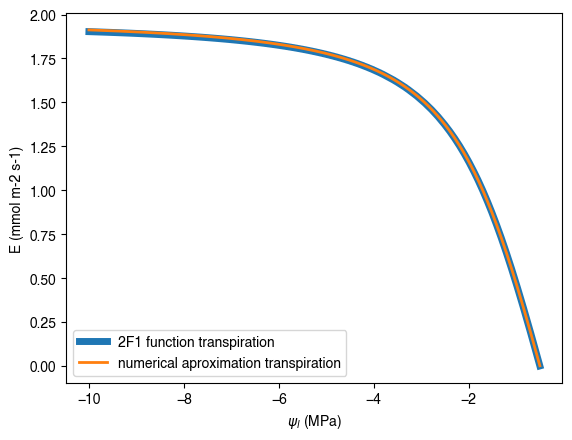

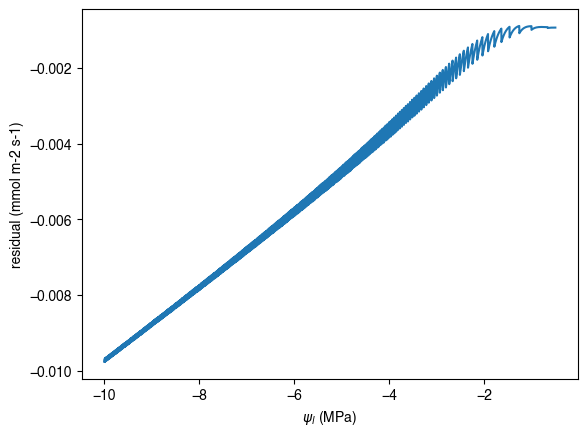

In [16]:
# -- Setup parameters --
psi_r = -0.5 # MPa
psi_l = np.linspace(psi_r, -10, 10000) # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
p50 = -2 # MPa
p88 = -4 # MPa

b = p50 #MPa
c = np.log(1/0.12-1) / np.log(p88/p50)

# -- calculate the transpiration rate using the 2F1 aproximation code --
transpiration_2F1_aproximation = np.zeros(len(psi_l))
for i in range(len(psi_l)):
    transpiration_2F1_aproximation[i] = transpiration_SOX(psi_r, psi_l[i], k_max, b, c, N = 1000, precision=0.001)

# -- calculate the transpiration using a numerical approach --
k_psi = k_SOX(psi_l, k_max, b, c)

transpiratio_numerical_aproximation = -np.cumsum(k_psi) * (psi_l[1]-psi_l[0])

plt.plot(psi_l, transpiration_2F1_aproximation, label = "2F1 function transpiration", linewidth = 5)
plt.plot(psi_l, transpiratio_numerical_aproximation, label = "numerical aproximation transpiration", linewidth = 2)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("E (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.plot(psi_l, transpiration_2F1_aproximation - transpiratio_numerical_aproximation)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("residual (mmol m-2 s-1)")
plt.show()

# Newton-Raphson method

Now that we have methods for calculating the transpiration rate and the conductance we can ipliment the Newton-Raphson method to determin the leaf water potential $\psi_l$.

The Newton-Raphson method is an iterative process for calculating the roots of a function ($f(x)=0$). The method works by calculating an updated estimate of the root $x_{n+1}$ using the value of the function $f(x_n)$ and its gradient, $f'(x_n)$, at the current estimate of the root $x_n$;

$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

As described previously we want to find the leaf water potential that satisfies the following;

$$ E_{obs} - \int_{\psi_r}^{\psi_l} k(\psi) d\psi = 0 $$

We already have the derivative for this equation since it is an integral of $k(\psi)$, meaning the updated estiaet of the leaf water potential is given by;

$$ \psi_{l,n+1} = \psi_{l,n} - \frac{E(\psi_{l,n}, \psi{r}) - E_{obs}}{k(\psi_{l,n})} $$

Where $E(\psi_{l,n}, \psi{r})$ is the transpiration rate integral.

The code bellow impliments the Newton-Raphson method and tests it on a single prediction using the cumulative Weibul conductnace model.

In [17]:
def NR(E_obs, psi_r, psi_l_init, E_func, K_func, k_max, b, c, Itters = 100, Precision = 0.01, verbose = False, itters_out = False):

    """
    Use the Newton-Raphson aproximation to estimate the leaf water potential for
    a given transpiration rate.
    """
    
    psi_l = psi_l_init
    
    for i in range(Itters):

        
        
        E_current = E_func(psi_r, psi_l, k_max, b , c)
        k_current = -K_func(psi_l, k_max, b, c)

        psi_l_new = psi_l - (E_current - E_obs)/k_current
        
        if( verbose ):
            print("\nitter    = ", i)
            print("psi_l     = ", psi_l)
            print("E_current = ", E_current)
            print("E_obs     = ", E_obs)
            print("k_current = ", k_current)
        
        if(np.abs(E_current - E_obs) < Precision):
            psi_l = psi_l_new
            break

        psi_l = psi_l_new

    if(itters_out):
        return psi_l, i
    return psi_l

## Initial testing

This section quickly applies a set of initial test to make sure that the implimentation is working.

### Cumulative Weibul
The code bellow test the Newton-Raphson method for a known leafwater potential and a cumulative Weibull distribution conductance model.

In [18]:
psi_r = -0.2 # MPa
psi_l_true = -4 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

E_obs = transpiration_CW(psi_r, psi_l_true, k_max, b, c)
k_obs = k_CW(psi_l_true, k_max, b, c)

psi_l_predicted = NR(E_obs, psi_r, psi_r, transpiration_CW, k_CW, k_max, b, c, Itters = 10, Precision = -0.0001, verbose = True)

print("\n-- results --")
print("E observed      = ", E_obs)
print("k observed.     = ", k_obs)
print("Predicted Psi_l = ", psi_l_predicted)
print("True Psi_l      = ", psi_l_true)
print("Difference      = ", psi_l_predicted - psi_l_true)


itter    =  0
psi_l     =  -0.2
E_current =  -0.0
E_obs     =  2.739369437673629
k_current =  -0.999981635315608

itter    =  1
psi_l     =  -2.9394197462526863
E_current =  2.4152191475221563
E_obs     =  2.739369437673629
k_current =  -0.5285826336241293

itter    =  2
psi_l     =  -3.552664051932947
E_current =  2.6562041462598045
E_obs     =  2.739369437673629
k_current =  -0.2638418519201395

itter    =  3
psi_l     =  -3.867872919701951
E_current =  2.721554469368451
E_obs     =  2.739369437673629
k_current =  -0.1565172983661162

itter    =  4
psi_l     =  -3.9816940020433167
E_current =  2.7372036068047327
E_obs     =  2.739369437673629
k_current =  -0.12542045248694328

itter    =  5
psi_l     =  -3.9989625641155317
E_current =  2.739249233457196
E_obs     =  2.739369437673629
k_current =  -0.12107694356598027

itter    =  6
psi_l     =  -3.999955356078169
E_current =  2.739364271193024
E_obs     =  2.739369437673629
k_current =  -0.1208302312476932

itter    =  7
psi_l     =

We can plot 10 steps to see this working.

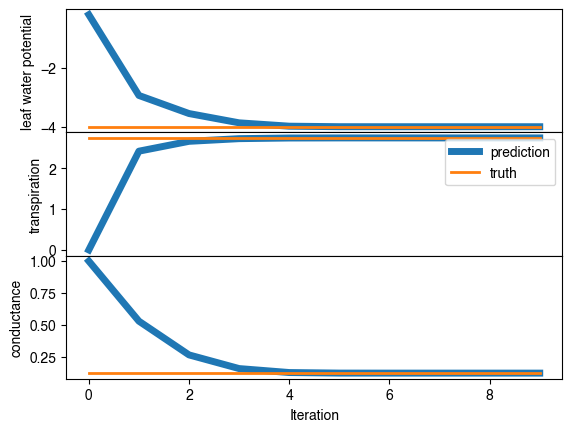

In [19]:
psi_r = -0.2 # MPa
psi_l_true = -4 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

E_obs = transpiration_CW(psi_r, psi_l_true, k_max, b, c)
k_obs = k_CW(psi_l_true, k_max, b, c)

steps = 10

psi_predict = np.ones(steps) * psi_r
E_predict = np.zeros(steps)
k_predict = np.zeros(steps)

k_predict[0] = k_CW(psi_r, k_max, b, c)

for i in range(1,steps):
    psi_predict[i] = NR(E_obs, psi_r, psi_predict[i-1], transpiration_CW, k_CW, k_max, b, c, Itters = 1, Precision = -0.0001)
    E_predict[i] = transpiration_CW(psi_r, psi_predict[i], k_max, b, c)
    k_predict[i] = k_CW(psi_predict[i], k_max, b, c)
    
# Plot the itterations to see what is going on.
fig, axs = plt.subplots(3,1, sharex = True)   

# Plot how the prediction changes
axs[0].plot([i for i in range(steps)], psi_predict, linewidth = 5)
axs[1].plot([i for i in range(steps)], E_predict,   linewidth = 5, label = "prediction")
axs[2].plot([i for i in range(steps)], k_predict,   linewidth = 5)

# Plot what this should tend to
axs[0].plot([i for i in range(steps)], np.ones(steps) * psi_l_true, linewidth = 2)
axs[1].plot([i for i in range(steps)], np.ones(steps) * E_obs,      linewidth = 2, label = "truth")
axs[2].plot([i for i in range(steps)], np.ones(steps) * k_obs,      linewidth = 2)

#formating
axs[0].set_ylabel("leaf water potential")
axs[1].set_ylabel("transpiration")
axs[2].set_ylabel("conductance")

axs[-1].set_xlabel("Iteration")

axs[1].legend()

fig.subplots_adjust(hspace=0)

plt.show()

### SOX
The code bellow test the Newton-Raphson method for a known leafwater potential and the SOX conductance model.

In [20]:
psi_r = -0.2 # MPa
psi_l_true = -4 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1
p50 = -2 # MPa
p88 = -4 # MPa

b = p50 #MPa
c = np.log(1/0.12-1) / np.log(p88/p50)

E_obs = transpiration_SOX(psi_r, psi_l_true, k_max, b, c)
k_obs = k_SOX(psi_l_true, k_max, b, c)

psi_l_predicted = NR(E_obs, psi_r, psi_r, transpiration_SOX, k_SOX, k_max, b, c, Itters = 100, Precision = 0.0001, verbose = True)

print("\n-- results --")
print("E observed      = ", E_obs)
print("k observed.     = ", k_obs)
print("Predicted Psi_l = ", psi_l_predicted)
print("True Psi_l      = ", psi_l_true)
print("Difference      = ", psi_l_predicted - psi_l_true)


itter    =  0
psi_l     =  -0.2
E_current =  0.0
E_obs     =  1.9818747769285538
k_current =  -0.9986666277283096

itter    =  1
psi_l     =  -2.1845208820452635
E_current =  1.5469253306200137
E_obs     =  1.9818747769285538
k_current =  -0.4369203878537811

itter    =  2
psi_l     =  -3.1800098965201373
E_current =  1.8524969004974334
E_obs     =  1.9818747769285538
k_current =  -0.20866388429680224

itter    =  3
psi_l     =  -3.8000399360601573
E_current =  1.9566065173981335
E_obs     =  1.9818747769285538
k_current =  -0.13645873974024375

itter    =  4
psi_l     =  -3.9852113628117145
E_current =  1.9802813179378904
E_obs     =  1.9818747769285538
k_current =  -0.12112888667304829

itter    =  5
psi_l     =  -3.9983664328732806
E_current =  1.9817000213355969
E_obs     =  1.9818747769285538
k_current =  -0.12012404550198037

itter    =  6
psi_l     =  -3.99982122564376
E_current =  1.9818556672817715
E_obs     =  1.9818747769285538
k_current =  -0.12001356743358182

-- results 

We can plot 10 steps to see this working.

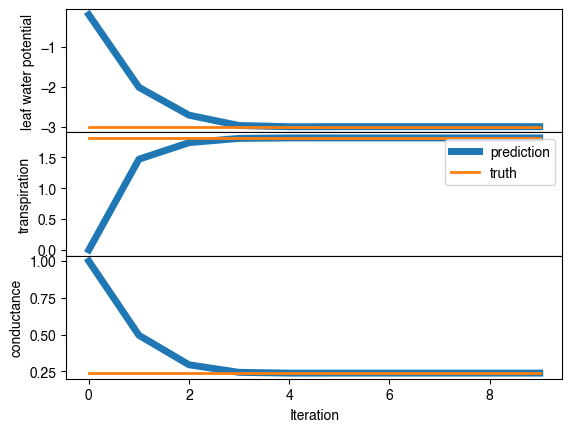

In [21]:
psi_r = -0.2 # MPa
psi_l_true = -3 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1
p50 = -2 # MPa
p88 = -4 # MPa

b = p50 #MPa
c = np.log(1/0.12-1) / np.log(p88/p50)

E_obs = transpiration_SOX(psi_r, psi_l_true, k_max, b, c)
k_obs = k_SOX(psi_l_true, k_max, b, c)

steps = 10

psi_predict = np.ones(steps) * psi_r
E_predict = np.zeros(steps)
k_predict = np.zeros(steps)

k_predict[0] = k_SOX(psi_r, k_max, b, c)

for i in range(1,steps):
    psi_predict[i] = NR(E_obs, psi_r, psi_predict[i-1], transpiration_SOX, k_SOX, k_max, b, c, Itters = 1, Precision = -0.0001)
    E_predict[i] = transpiration_SOX(psi_r, psi_predict[i], k_max, b, c)
    k_predict[i] = k_SOX(psi_predict[i], k_max, b, c)
    
# Plot the itterations to see what is going on.
fig, axs = plt.subplots(3,1, sharex = True)   

# Plot how the prediction changes
axs[0].plot([i for i in range(steps)], psi_predict, linewidth = 5)
axs[1].plot([i for i in range(steps)], E_predict,   linewidth = 5, label = "prediction")
axs[2].plot([i for i in range(steps)], k_predict,   linewidth = 5)

# Plot what this should tend to
axs[0].plot([i for i in range(steps)], np.ones(steps) * psi_l_true, linewidth = 2)
axs[1].plot([i for i in range(steps)], np.ones(steps) * E_obs,      linewidth = 2, label = "truth")
axs[2].plot([i for i in range(steps)], np.ones(steps) * k_obs,      linewidth = 2)

#formating
axs[0].set_ylabel("leaf water potential")
axs[1].set_ylabel("transpiration")
axs[2].set_ylabel("conductance")

axs[-1].set_xlabel("Iteration")

axs[1].legend()

fig.subplots_adjust(hspace=0)

plt.show()

# Accuracy testing

## Cumulative Weibull conductance model
Lets plot the predicted leaf water potential and the true leaf water potential.

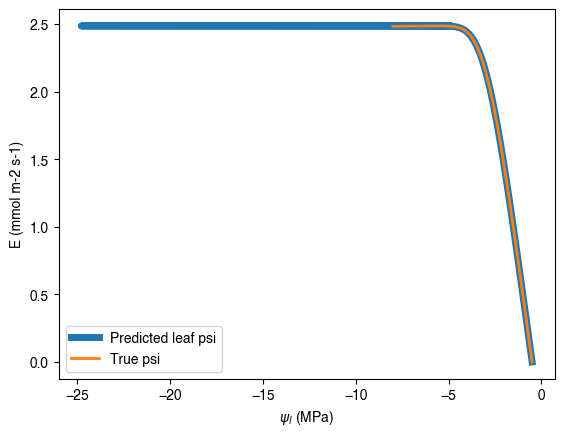

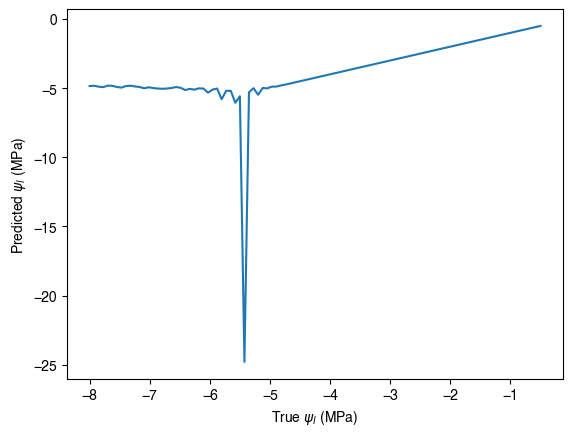

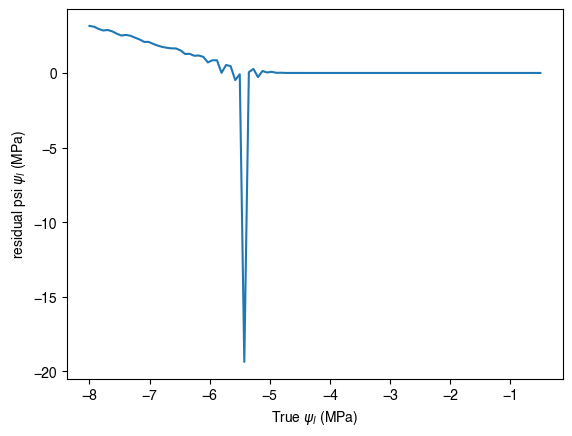

In [22]:
# -- Setup parameters --
psi_r = -0.5 # MPa
psi_l_true = np.linspace(psi_r, -8, 100) # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89

# -- calculate the transpiration rate using the gamma aproximation code --
E_obs = np.zeros(len(psi_l_true))
for i in range(len(psi_l_true)):
    E_obs[i] = transpiration_CW(psi_r, psi_l_true[i], k_max, b, c, N = 100, precision=0.001)

# -- Setup the transpiration calculation --
#  This is done to set the precision and iterations ofthe transpiration calculation
def transpiration_CW_NR(psi_r, psi_l, k_max, b, c):
    return transpiration_CW(psi_r, psi_l, k_max, b, c, N = 100, precision=0.001)

# -- Predict the leaf water potential --
psi_l_predict = np.zeros(len(psi_l_true))
itters_out = [0 for i in range(len(psi_l_true))]
for i in range(len(psi_l_true)):
    psi_l_predict[i], itters_out[i] = NR(E_obs[i], psi_r, psi_r, transpiration_CW_NR, k_CW, k_max, b, c,
                                         Itters = 10, Precision = 0.0001, itters_out = True)

plt.plot(psi_l_predict, E_obs, label = "Predicted leaf psi", linewidth = 5)
plt.plot(psi_l_true, E_obs, label = "True psi", linewidth = 2)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("E (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.plot(psi_l_true, psi_l_predict)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("Predicted $\psi_l$ (MPa)")
plt.show()

plt.plot(psi_l_true, psi_l_predict - psi_l_true)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("residual psi $\psi_l$ (MPa)")
plt.show()

Lets look at howmany iterations each prediction takes.

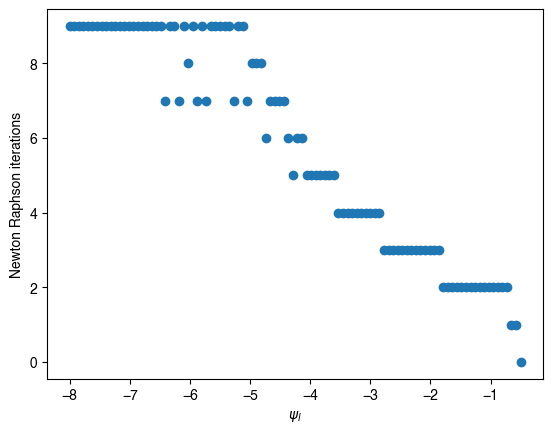

In [23]:
plt.scatter(psi_l_true, itters_out)
plt.xlabel("$\psi_l$")
plt.ylabel("Newton Raphson iterations")
plt.show()

## SOX conductance model
Lets plot the predicted leaf water potential and the true leaf water potential for the SOX conductance model.

error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.0| >= 1
error: |1.

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/570008313.py:10: RuntimeWarning: overflow encountered in scalar power
  x_l = -(psi_l/b)**c
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/1883992881.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.power(1-x, -a_f) * HGS_2F1_mod_of_x_lessthan_1(a_f, c_f - b_f, c_f, x / (x - 1), itters, precision, verbose)
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/2763901701.py:5: RuntimeWarning: overflow encountered in scalar power
  return k_max / (1 + (psi/b)**c)
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/1269957321.py:17: RuntimeWarning: overflow encountered in scalar divide
  psi_l_new = psi_l - (E_current - E_obs)/k_current


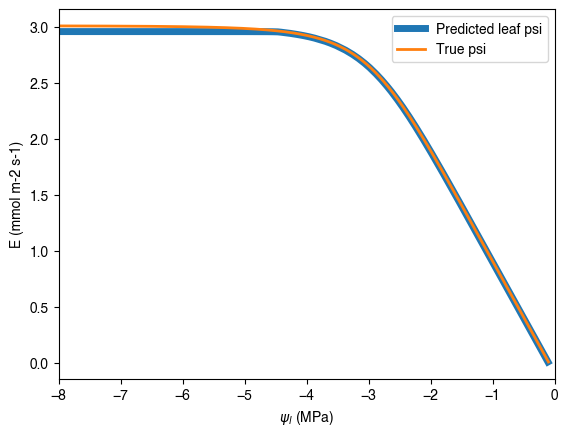

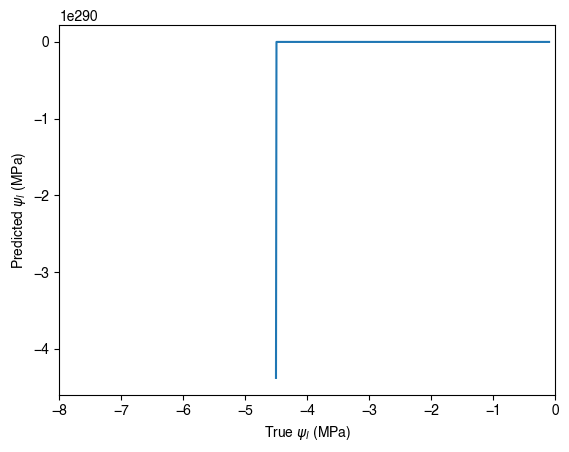

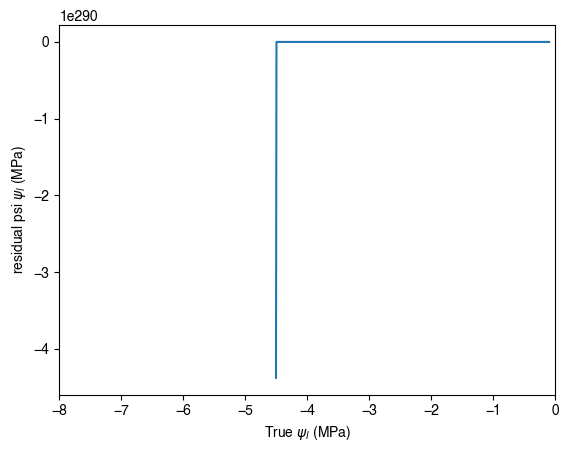

In [24]:
# -- Setup parameters --
psi_r = -0.1 # MPa
psi_l_true = np.linspace(psi_r, -8, 1000) # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
p50 = -3 # MPa
p88 = -4 # MPa

b = p50 #MPa
c = np.log(1/0.12-1) / np.log(p88/p50)

# -- calculate the transpiration using a numerical approach --
k_psi = k_SOX(psi_l_true, k_max, b, c)

E_obs = -np.cumsum(k_psi) * (psi_l_true[1]-psi_l_true[0])

# -- Setup the transpiration calculation --
#  This is done to set the precision and iterations ofthe transpiration calculation
def transpiration_SOX_NR(psi_r, psi_l, k_max, b, c):
    return transpiration_SOX(psi_r, psi_l, k_max, b, c, N = 100, precision=0.001)

# -- Predict the leaf water potential --
psi_l_predict = np.zeros(len(psi_l_true))
itters_out = [0 for i in range(len(psi_l_true))]
for i in range(len(psi_l_true)):
    psi_l_predict[i], itters_out[i] = NR(E_obs[i], psi_r, psi_r, transpiration_SOX_NR, k_SOX, k_max, b, c,
                                         Itters = 10, Precision = 0.0001, itters_out = True)

plt.plot(psi_l_predict, E_obs, label = "Predicted leaf psi", linewidth = 5)
plt.plot(psi_l_true, E_obs, label = "True psi", linewidth = 2)
plt.xlim(-8, 0)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("E (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.plot(psi_l_true, psi_l_predict)
plt.xlim(-8, 0)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("Predicted $\psi_l$ (MPa)")
plt.show()

plt.plot(psi_l_true, psi_l_predict - psi_l_true)
plt.xlim(-8, 0)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("residual psi $\psi_l$ (MPa)")
plt.show()

Lets look at howmany iterations the Newton Rasphon prediction takes.

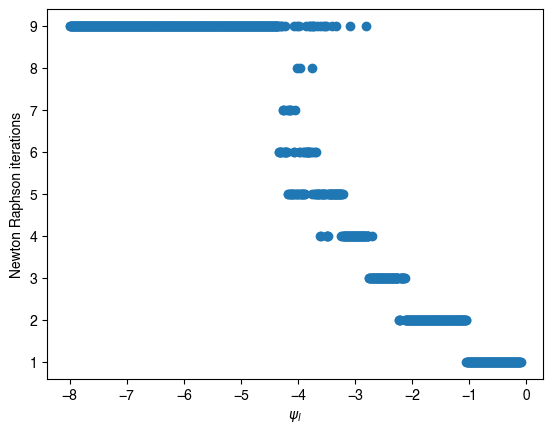

In [25]:
plt.scatter(psi_l_true, itters_out)
plt.xlabel("$\psi_l$")
plt.ylabel("Newton Raphson iterations")
plt.show()

# Damaged xylem model

As part of implimentig xylem damage due to extream water potentials it is necessary to impliment the Newton Raphson mehtod to solve for water potential as a function of leaf water potentil.

We define a conductance model that is an updated version of the cumulative Weibul function where the conductance is capped at a value below $k_{max}$. This new conductance model can be writen as,

$$
k(\psi) = 
\begin{cases}
k_{max}e^{-(\frac{\psi}{b})^c}, \psi \leq \psi_{cap}\\
k_{cap}, \psi \geq \psi_{cap}
\end{cases}
$$

where $\psi_{cap}$ is the water potential that satisfies

$$
k_{cap} = k_{max}e^{-(\frac{\psi_{cap}}{b})^c}
$$

The code below impliments and plots this conductance model. A function to calculate the water potential, $\psi_{cap}$, at which the function switches is also incuded.

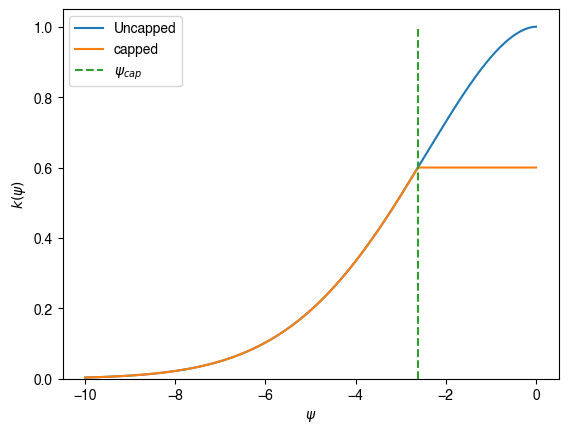

In [26]:
def caped_cumulative_weibul(psi, k_max, b, c, k_cap):
    # Calculate the conductance for the cumulative weibul distribution without the cap
    k_out = k_max * np.exp(-(psi/b)**c)

    # Apply cap to conductance
    k_out = np.clip(k_out, 0, k_cap)

    return k_out

def get_psi_cap(k_max, b, c, k_cap):
    return b * np.log(k_max/k_cap)**(1/c)

k_max = 1
b = -3.8 # MPa
c = 1.8
k_cap = 0.6

psi_cap = get_psi_cap(k_max, b, c, k_cap)

psi_array = np.linspace(0, -10, 1000)

k_original = caped_cumulative_weibul(psi_array, k_max, b, c, 1.1*k_max)
k_array = caped_cumulative_weibul(psi_array, k_max, b, c, k_cap)

plt.plot(psi_array, k_original, label = "Uncapped")
plt.plot(psi_array, k_array, label = "capped")
plt.plot([psi_cap, psi_cap], [0,k_max], linestyle = "--", label = "$\psi_{cap}$")
plt.xlabel("$\psi$")
plt.ylabel("$k(\psi)$")
plt.ylim(0,1.05)
plt.legend()
plt.show()

Using a numerical integration approach the code bellow plots transpiration rate $E$ as a function of the upper limit on water potential $\psi$, the lower limit being set to zero.

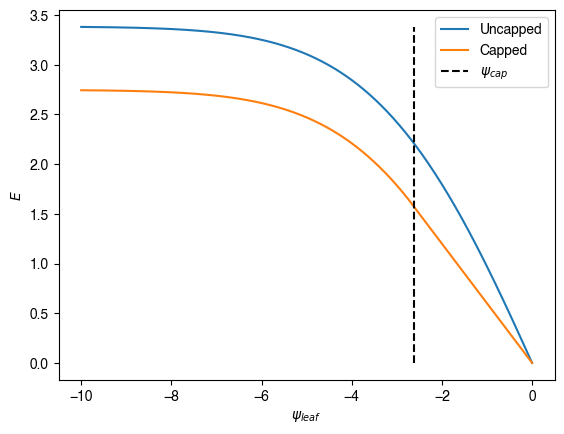

In [27]:
def transpiration_caped_cumulative_weibul(psi_min, psi_max, k_max, b, c, k_cap, N = 1000):
    psi_array = np.linspace(psi_min, psi_max, N)

    # Conductance
    k_array = caped_cumulative_weibul(psi_array, k_max, b, c, k_cap)

    return - np.sum(k_array) * (psi_array[1] - psi_array[0])

k_max = 1
b = -3.8 # MPa
c = 1.8
k_cap = 0.6

psi_cap = get_psi_cap(k_max, b, c, k_cap)

samples = 1000
psi_array = np.linspace(0, -10, samples)
E_original = np.zeros(samples)
E_capped = np.zeros(samples)

N = 1000

for i in range(1,N):
    E_original[i] = transpiration_caped_cumulative_weibul(psi_array[0], psi_array[i], k_max, b, c, 1.1*k_max, N)
    E_capped[i] = transpiration_caped_cumulative_weibul(psi_array[0], psi_array[i], k_max, b, c, k_cap, N)

plt.plot(psi_array, E_original, label = "Uncapped")
plt.plot(psi_array, E_capped, label = "Capped")
plt.plot([psi_cap, psi_cap], [0,E_original[-1]], linestyle = "--", label = "$\psi_{cap}$", c = "black")
plt.xlabel("$\psi_{leaf}$")
plt.ylabel("$E$")
plt.legend()
plt.show()

To find the leaf water potential that satisfies the integral of the capped cumulative Weibull function with known transpiration $E$ and root zone water potential $\psi_r$, we need an analytical solution to the integral of $k(\psi)$ over the range $[\psi_r, \psi_l]$. To achive this let use first seperate the problem into three versions dependent on the values of $\psi_r$ and $psi_l$ relative to $\psi_{cap}$.

1. $\psi_r, \psi_l \leq \psi_{cap}$

$$
E = -\int_{psi_r}^{\psi_l} k_{cap} d\psi = -k_{cap}(\psi_l - \psi_r)
$$

2. $\psi_r > \psi_{cap} > \psi_l$

$$
E = -\int_{\psi_r}^{\psi_{cap}} k_{cap} d\psi - \int_{\psi_{cap}}^{\psi_l} k_{cw}(\psi) d\psi
$$
$$
= -k_{cap}(\psi_{cap} - \psi_r) - \int_{\psi_{cap}}^{\psi_l} k_{cw}(\psi) d\psi
$$

3. $\psi_{cap} \geq \psi_r, \psi_l$

$$
E = -\int_{\psi_r}^{\psi_{cap}} k_{cw}(\psi) d\psi
$$

In the equations above $k_{cw}(\psi)$ is the uncapped cumulative Weibull distribution described in previous sections.

Given that we don't know and are trying to find $\psi_L$, the conditions above need to be redefined interms of $\psi_r$ and $E$

1. $\psi_r \leq \psi_{cap}$ and $E \leq -k_{cap}(\psi_{cap} - \psi_r)$
2. $\psi_r \leq \psi_{cap}$ and $E > -k_{cap}(\psi_{cap} - \psi_r)$
3. $\psi_{cap} \leq \psi_r$

The soultion for calculating $\psi_l$ under the first pair of conditions is trivial,

$$
\psi_l = \psi_r - \frac{E}{k_cap}
$$

For the second and third set of conditions we need the Newton Raphson method used to find $\psi_l$ given $E$ and $\psi_r$ defined for a cumulative Weibul conductance model from the previous sections. We define the function $\psi_{cwl}(E, \psi_r) as the value leaf water potential that satisies the equation,

$$
E = \int_{\psi_r}^{\psi_{cwl}} k_{cw}(\psi)d\psi
$$

where $k_{cw}$ is the cumulative Weibull distribution. Given this the solution for the second set of conditions, $\psi_r > \psi_{cap}$ and $E \leq -k_{cap}(\psi_{cap} - \psi_r)$, is;

$$
\psi_l = \psi_{cwl}(E - k_{cap}(\psi_r - \psi_{cap}), \psi_{cap})
$$

What we are doing here is first calculating the component of the transpiration due to the integration between $\psi_r$ and $\psi_{cap}$ where the conductance is constant, $k_{cap}(\psi_{cap} - \psi_r)$. Subtracting this from the full transpiration $E$ then gives the component of the transpiration due to the intergration of the cumulative Weibull function from $\psi_{cap}$ to $\psi_l$. Providing this second component of the transpiration along with the start of the intergration, $\psi_{cap}$, to $\psi_{cwl}()$ gives the leaf water potential, $\psi_l$.

With respect to the third set of coditions the intergration occurs only over the cumulative weibul distribution hence we can simply use the previous Newton Raphson solution.

$$
\psi_l = psi_{cwl}(E, \psi_r)
$$

The code bellow impliments this set of solutions.

In [38]:
def Psi_l_for_cumulative_weibul(psi_r, k_max, b, c, k_cap, E, Itters = 10, Precision = -0.0001, verbose = False):

    # Set psi_l to psi_r incase it is accedentaly not set later.
    psi_l = psi_r
    
    # Get the water potential at which the conducatnce model switches
    psi_cap = get_psi_cap(k_max, b, c, k_cap)

    # Is the root water potential more or less than psi_cap
    if(psi_r > psi_cap):
        if(verbose):
            print("psi_r (", psi_r, ") > psi_cap (", psi_cap, ")")
        # Calculate the transpiration for the water potential range psi_r to psi_cap
        E_cap = k_cap*(psi_r - psi_cap)

        # Is the leaf water potential more or less than psi_cap
        # psi_l <= psi_cap
        if(E <= E_cap):
            if(verbose):
                print("E (", E, ") <= E_cap (", E_cap, ")")
            psi_l = psi_r - E/k_cap

        # psi_cap < psi_l
        else:
            if(verbose):
                print("E_cap (", E_cap, ") < E (", E, ")")

            # Calculate psi_l given transpiration intergrated from psi_cap to psi_l
            psi_l = NR(E - E_cap, psi_cap, psi_cap, transpiration_CW, k_CW, k_max, b, c, Itters, Precision, verbose)

    # psi_cap <= psi_r
    else:
        if(verbose == True):
            print("psi_r (", psi_r, ") < psi_cap (", psi_cap, ")")

        # Just need to use the existing Newton Raphson method
        psi_l = NR(E, psi_r, psi_r, transpiration_CW, k_CW, k_max, b, c, Itters, Precision, verbose)
        
    return psi_l

Having implimented the solution above, the code below finds $\psi_l$ for a range of $E$.

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/1248760541.py:17: RuntimeWarning: overflow encountered in scalar multiply
  step *= x/denominator
/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_22298/1248760541.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  return summ  * np.exp(-x) * np.power(x,a)


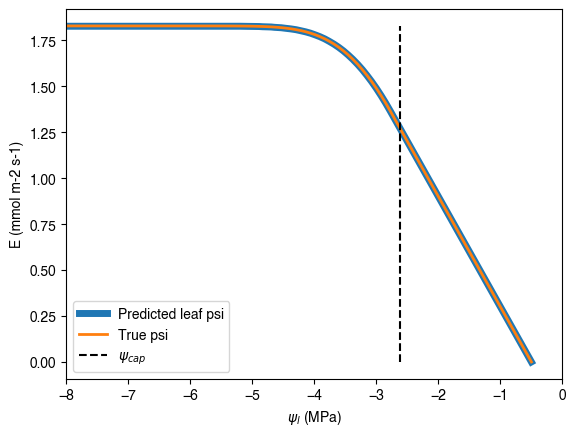

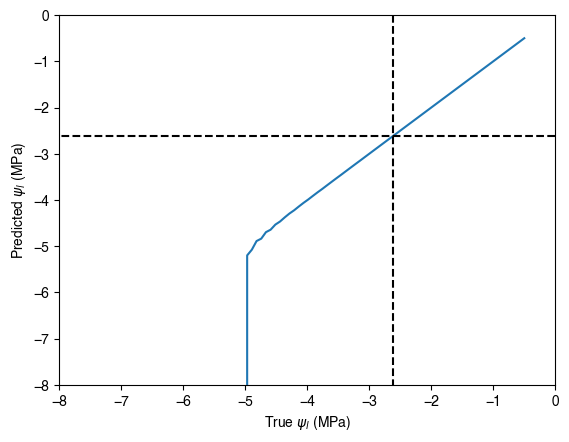

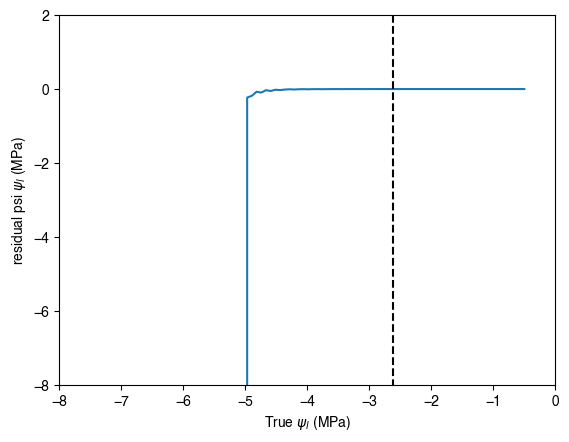

In [48]:
# -- Setup parameters --
psi_r = -0.5 # MPa
psi_l_true = np.linspace(psi_r, -8, 100) # MPa

k_max = 1 # mmol m-2 s-1 MPa-1
b = -3.3 # MPa
c = 3.89
k_cap = 0.6 # mmol m-2 s-1 MPa-1

N = 10000

# -- calculate the transpiration rate using a numerical aproximation --
E_obs = np.zeros(len(psi_l_true))
for i in range(len(psi_l_true)):
    E_obs[i] = transpiration_caped_cumulative_weibul(psi_r, psi_l_true[i], k_max, b, c, k_cap, N)

# -- Predict the leaf water potential --
psi_l_predict = np.zeros(len(psi_l_true))
for i in range(len(psi_l_true)):
    psi_l_predict[i] = Psi_l_for_cumulative_weibul(psi_r, k_max, b, c, k_cap, E_obs[i])#, verbose = True)

plt.plot(psi_l_predict, E_obs, label = "Predicted leaf psi", linewidth = 5)
plt.plot(psi_l_true, E_obs, label = "True psi", linewidth = 2)
plt.plot([psi_cap, psi_cap], [0,E_obs[-1]], linestyle = "--", label = "$\psi_{cap}$", c = "black")
plt.xlim(psi_l_true[-1],0)
plt.xlabel("$\psi_l$ (MPa)")
plt.ylabel("E (mmol m-2 s-1)")
plt.legend()
plt.show()

plt.plot(psi_l_true, psi_l_predict)
plt.plot([psi_cap, psi_cap], [0,psi_l_true[-1]], linestyle = "--", label = "$\psi_{cap}$", c = "black")
plt.plot([0,psi_l_true[-1]], [psi_cap, psi_cap], linestyle = "--", label = "$\psi_{cap}$", c = "black")
plt.xlim(psi_l_true[-1],0)
plt.ylim(psi_l_true[-1],0)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("Predicted $\psi_l$ (MPa)")
plt.show()

plt.plot(psi_l_true, psi_l_predict - psi_l_true)
plt.plot([psi_cap, psi_cap], [2,psi_l_true[-1]], linestyle = "--", label = "$\psi_{cap}$", c = "black")
plt.xlim(psi_l_true[-1],0)
plt.ylim(psi_l_true[-1],2)
plt.xlabel("True $\psi_l$ (MPa)")
plt.ylabel("residual psi $\psi_l$ (MPa)")
plt.show()